In [1]:
!pip install category_encoders

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


imports

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3)
from scipy import interp

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Imputer,OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer,QuantileTransformer
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import make_pipeline,Pipeline,FeatureUnion
import category_encoders
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import roc_curve, auc

from itertools import cycle

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold,RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA, TruncatedSVD

import glob

%matplotlib inline

In [4]:
source_dir = "dataset"
suffix_train = "/train/"
suffix_test =  "/test/"

filname_subs_features_train = "subs_features_train.csv"
filname_subs_features_test= "subs_features_test.csv"

filname_y_train = "subs_csi_train.csv"
filname_y_test = "subs_csi_test.csv"

target = "CSI"
seed = 33

Считаем train/test файлы.

In [5]:
#dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%y')

df_sfeatures_train = pd.read_csv(source_dir + suffix_train + filname_subs_features_train, 
                             header=0, sep = ';', decimal=",",
                           parse_dates=['SNAP_DATE'])

df_sfeatures_test = pd.read_csv(source_dir + suffix_test + filname_subs_features_test, 
                             header=0, sep = ';', decimal=",",
                           parse_dates=['SNAP_DATE'])

df_y_train = pd.read_csv(source_dir + suffix_train + filname_y_train, 
                             header=0, sep = ';', decimal=",")

df_y_test_pred = pd.read_csv(source_dir + suffix_test + filname_y_test, 
                             header=0, sep = ';', decimal=",")

In [6]:
df_union_test = pd.merge(df_y_test_pred,df_sfeatures_test, on=['SK_ID'])

In [7]:
df_union_train = pd.merge(df_y_train, df_sfeatures_train,  on=['SK_ID'])

In [8]:
df = pd.concat([df_union_train,df_union_test], axis=0, sort = False)

In [9]:
df.shape

(106400, 38)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106400 entries, 0 to 58988
Data columns (total 38 columns):
SK_ID               106400 non-null int64
CSI                 47411 non-null float64
CONTACT_DATE        106400 non-null object
SNAP_DATE           106400 non-null datetime64[ns]
COM_CAT#1           106400 non-null int64
COM_CAT#2           106400 non-null int64
COM_CAT#3           106400 non-null int64
BASE_TYPE           106400 non-null int64
ACT                 106400 non-null int64
ARPU_GROUP          106358 non-null float64
COM_CAT#7           106400 non-null int64
COM_CAT#8           101541 non-null float64
DEVICE_TYPE_ID      106098 non-null float64
INTERNET_TYPE_ID    106098 non-null float64
REVENUE             106400 non-null float64
ITC                 106400 non-null float64
VAS                 106400 non-null float64
RENT_CHANNEL        106400 non-null float64
ROAM                106400 non-null float64
COST                106400 non-null float64
COM_CAT#17         

In [11]:
# set option to view more columns as by default
pd.set_option('display.max_columns', df.shape[1])

In [12]:
df.columns = df.columns.str.replace("[#]", "_")

In [13]:
df.head()

,SK_ID,CSI,CONTACT_DATE,SNAP_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_24,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
0,2,0.0,04.05,2002-01-03,7,77,10,1,1,10.0,2,1318.0,5.0,2.0,0.133708,0.007335,0.084167,0.055325,0.0,0.004982,0.0,0.0,0.026212,0.706893,0.019298,0.706893,0.133897,31.12,1,1,0.002070,0.007335,0.000050,0.002785,0.029765,0.027579,0.103896,NaN
1,2,0.0,04.05,2002-01-02,7,77,9,1,1,10.0,2,1318.0,5.0,2.0,0.134224,0.001590,0.084167,0.055312,0.0,0.004396,0.0,0.0,0.026212,0.707528,0.019298,0.707528,0.134836,31.12,1,1,0.003913,0.001590,0.000018,0.001954,0.054871,0.027579,0.103896,NaN
2,2,0.0,04.05,2002-01-05,7,77,12,1,1,9.0,2,1318.0,5.0,2.0,0.128917,0.008331,0.084167,0.055257,0.0,0.005078,0.0,0.0,0.026212,0.705129,0.019298,0.705129,0.129093,31.12,1,1,0.001801,0.008317,0.000081,0.002441,0.018126,0.027579,0.103896,9.0
3,2,0.0,04.05,2002-01-01,7,77,17,1,1,6.0,2,1318.0,5.0,2.0,0.117077,0.002301,0.084167,0.055353,0.0,0.004471,0.0,0.0,0.087185,0.701424,0.086379,0.697846,0.118129,31.12,1,0,0.001798,0.002048,0.000033,0.002331,0.022108,0.027579,0.103896,NaN
4,2,0.0,04.05,2002-01-04,7,77,11,1,1,8.0,2,1318.0,5.0,2.0,0.126715,0.002080,0.084167,0.055187,0.0,0.004436,0.0,0.0,0.026212,0.704850,0.019298,0.704850,0.126587,31.12,1,1,0.006520,0.001408,0.000010,0.001709,0.022772,0.027579,0.103896,9.0


In [14]:
df.tail()

,SK_ID,CSI,CONTACT_DATE,SNAP_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_24,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
58984,6156,NaN,14.04,2002-01-03,4,54,5,2,1,4.0,3,1324.0,5.0,2.0,0.110392,0.000728,0.084167,0.054969,0.0,0.004281,0.0,0.0,0.026212,0.699214,0.019298,0.699214,0.111080,31.12,1,1,0.003236,0.000728,0.000000,0.000000,0.003116,0.027579,0.103896,10.0
58985,6156,NaN,14.04,2001-01-08,4,54,5,2,1,1.0,3,1324.0,5.0,2.0,0.108153,0.000000,0.084167,0.054966,0.0,0.004206,0.0,0.0,0.026212,0.698482,0.019298,0.698482,0.109461,31.12,1,1,0.000569,0.000000,0.000000,0.000000,0.000862,0.027579,0.103896,9.0
58986,6156,NaN,14.04,2001-01-05,4,54,5,2,1,2.0,3,1324.0,5.0,2.0,0.108803,0.002199,0.084418,0.055716,0.0,0.004506,0.0,0.0,0.026212,0.698480,0.019298,0.698480,0.109534,31.12,1,1,0.003103,0.002199,0.001328,0.005336,0.023826,0.027579,0.103896,2.0
58987,6156,NaN,14.04,2002-01-04,4,54,5,2,1,1.0,3,1324.0,5.0,2.0,0.108261,0.000000,0.084167,0.054968,0.0,0.004207,0.0,0.0,0.026212,0.698520,0.019298,0.698520,0.109409,31.12,1,1,0.001198,0.000000,0.000000,0.000000,0.002594,0.027579,0.103896,10.0
58988,6156,NaN,14.04,2001-01-10,4,54,5,2,1,4.0,3,1324.0,5.0,2.0,0.110345,0.000177,0.084167,0.054971,0.0,0.004225,0.0,0.0,0.026212,0.699241,0.019298,0.699241,0.109618,31.12,1,1,0.009500,0.000000,0.000000,0.000000,0.005362,0.027579,0.103896,9.0


In [15]:
df.describe()

,SK_ID,CSI,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
count,106400.000000,47411.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106358.000000,106400.000000,101541.000000,106098.000000,106098.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,102936.000000
mean,4876.034201,0.156694,4.503421,41.075367,5.271100,1.939070,0.990705,7.580370,2.400451,870.832580,4.610162,1.908113,0.128907,0.018490,0.087468,0.057185,0.000050,0.006531,0.003301,0.003521,0.026593,0.704000,0.019748,0.703853,0.126349,0.999878,0.988769,0.016675,0.017986,0.004444,0.004695,0.045831,0.028238,0.104961,5.582323
std,2812.580460,0.363515,2.182422,22.237932,2.783232,0.239204,0.095962,3.231712,1.625670,515.018465,0.898524,0.726753,0.020725,0.031818,0.012046,0.012992,0.003958,0.005383,0.020150,0.026469,0.010831,0.006346,0.004545,0.006369,0.018020,0.011053,0.105381,0.024760,0.030927,0.015495,0.021385,0.051868,0.009022,0.009838,3.557936
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2436.000000,0.000000,3.000000,25.000000,5.000000,2.000000,1.000000,5.000000,1.000000,391.000000,5.000000,1.000000,0.115454,0.001027,0.084167,0.054996,0.000000,0.004429,0.000000,0.000000,0.026212,0.700358,0.019298,0.700214,0.115037,1.000000,1.000000,0.002037,0.000960,0.000000,0.000000,0.010774,0.027579,0.103896,2.000000
50%,4889.000000,0.000000,4.000000,38.000000,5.000000,2.000000,1.000000,8.000000,2.000000,926.000000,5.000000,2.000000,0.124508,0.006953,0.084212,0.055156,0.000000,0.005209,0.000000,0.000000,0.026212,0.702849,0.019298,0.702705,0.122497,1.000000,1.000000,0.008221,0.006679,0.000070,0.000000,0.030382,0.027579,0.103896,4.000000
75%,7310.000000,0.000000,6.000000,60.000000,5.000000,2.000000,1.000000,10.000000,3.000000,1318.000000,5.000000,2.000000,0.136094,0.022675,0.086573,0.056061,0.000000,0.007087,0.000000,0.000000,0.026212,0.705948,0.019298,0.705816,0.131878,1.000000,1.000000,0.021532,0.022035,0.002882,0.000190,0.062889,0.027579,0.103896,9.000000
max,9748.000000,1.000000,8.000000,83.000000,17.000000,2.000000,1.000000,12.000000,9.000000,1702.000000,8.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000


Missing values

In [16]:
print (pd.concat([1- df.count() / df.shape[0], df.isna().sum()],axis=1))

                         0      1
SK_ID             0.000000      0
CSI               0.554408  58989
CONTACT_DATE      0.000000      0
SNAP_DATE         0.000000      0
COM_CAT_1         0.000000      0
COM_CAT_2         0.000000      0
COM_CAT_3         0.000000      0
BASE_TYPE         0.000000      0
ACT               0.000000      0
ARPU_GROUP        0.000395     42
COM_CAT_7         0.000000      0
COM_CAT_8         0.045667   4859
DEVICE_TYPE_ID    0.002838    302
INTERNET_TYPE_ID  0.002838    302
REVENUE           0.000000      0
ITC               0.000000      0
VAS               0.000000      0
RENT_CHANNEL      0.000000      0
ROAM              0.000000      0
COST              0.000000      0
COM_CAT_17        0.000000      0
COM_CAT_18        0.000000      0
COM_CAT_19        0.000000      0
COM_CAT_20        0.000000      0
COM_CAT_21        0.000000      0
COM_CAT_22        0.000000      0
COM_CAT_23        0.000000      0
COM_CAT_24        0.000000      0
COM_CAT_25    

Duplicates by SK_ID

Гипотеза - возможно стоит группировать и брать средние за 12 месяцев!

In [17]:
df[df.SK_ID == 3339].sort_values('SNAP_DATE',ascending=False) #3608

,SK_ID,CSI,CONTACT_DATE,SNAP_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_24,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
33587,3339,1.0,13.05,2002-01-05,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.152648,0.071165,0.088724,0.058856,0.0,0.012058,0.0,0.0,0.026212,0.708091,0.019298,0.708091,0.138358,31.12,1,1,0.068973,0.071165,0.060654,0.010096,0.109189,0.027579,0.103896,2.0
33588,3339,1.0,13.05,2002-01-04,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.146904,0.039467,0.090637,0.061338,0.0,0.009152,0.0,0.0,0.026212,0.708316,0.019298,0.708316,0.139378,31.12,1,1,0.037451,0.037747,0.065096,0.063092,0.092053,0.027579,0.103896,2.0
33585,3339,1.0,13.05,2002-01-03,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.153125,0.089727,0.086884,0.062059,0.0,0.014080,0.0,0.0,0.026212,0.706693,0.019298,0.706693,0.138393,31.12,1,1,0.069798,0.086321,0.045110,0.081978,0.107824,0.027579,0.103896,2.0
33583,3339,1.0,13.05,2002-01-02,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.144922,0.047471,0.090825,0.058738,0.0,0.009774,0.0,0.0,0.026212,0.707135,0.019298,0.707135,0.135779,31.12,1,1,0.046714,0.047219,0.033011,0.031543,0.062931,0.027579,0.103896,2.0
33578,3339,1.0,13.05,2002-01-01,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.150506,0.048746,0.090899,0.056983,0.0,0.009771,0.0,0.0,0.026212,0.709107,0.019298,0.709107,0.139332,31.12,1,1,0.055658,0.048290,0.026180,0.014695,0.073732,0.027579,0.103896,2.0
33580,3339,1.0,13.05,2001-01-12,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.152471,0.087388,0.088690,0.058714,0.0,0.013697,0.0,0.0,0.026212,0.706760,0.019298,0.706760,0.136914,31.12,1,1,0.073945,0.086367,0.032632,0.017697,0.107121,0.027579,0.103896,2.0
33584,3339,1.0,13.05,2001-01-11,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.162482,0.073122,0.095195,0.060743,0.0,0.012831,0.0,0.0,0.026212,0.710960,0.019298,0.710960,0.145504,31.12,1,1,0.080417,0.072672,0.058086,0.036068,0.134986,0.027579,0.103896,2.0
33581,3339,1.0,13.05,2001-01-10,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.142156,0.033726,0.089917,0.059585,0.0,0.008382,0.0,0.0,0.026212,0.707238,0.019298,0.707238,0.135508,31.12,1,1,0.035139,0.033726,0.030531,0.053506,0.114678,0.027579,0.103896,2.0
33582,3339,1.0,13.05,2001-01-09,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.145285,0.050051,0.084167,0.059378,0.0,0.009651,0.0,0.0,0.026212,0.707359,0.019298,0.707359,0.134488,31.12,1,1,0.053856,0.050051,0.033896,0.042431,0.106840,0.027579,0.103896,2.0
33577,3339,1.0,13.05,2001-01-08,4,80,5,2,1,12.0,1,1489.0,5.0,2.0,0.153024,0.081527,0.104168,0.058596,0.0,0.014106,0.0,0.0,0.026212,0.706638,0.019298,0.706638,0.147071,31.12,1,1,0.031696,0.076724,0.040279,0.013300,0.083382,0.027579,0.103896,2.0


#### Time features.

In [18]:
df.SNAP_DATE =pd.to_datetime(df.SNAP_DATE, format='%d/%m/%Y').dt.date

In [19]:
df.SNAP_DATE.unique()

array([datetime.date(2002, 1, 3), datetime.date(2002, 1, 2),
       datetime.date(2002, 1, 5), datetime.date(2002, 1, 1),
       datetime.date(2002, 1, 4), datetime.date(2001, 1, 12),
       datetime.date(2001, 1, 10), datetime.date(2001, 1, 9),
       datetime.date(2001, 1, 11), datetime.date(2001, 1, 8),
       datetime.date(2001, 1, 7), datetime.date(2001, 1, 6),
       datetime.date(2001, 1, 5)], dtype=object)

In [20]:
df.SNAP_DATE.value_counts()

2002-01-04    9369
2002-01-03    9274
2002-01-02    9134
2002-01-01    9038
2001-01-12    8961
2001-01-11    8857
2001-01-10    8783
2001-01-09    8689
2001-01-08    8591
2001-01-07    8484
2001-01-06    8367
2002-01-05    4524
2001-01-05    4329
Name: SNAP_DATE, dtype: int64

Посмотрим на величину COM_CAT_24.

In [21]:
df.COM_CAT_24.unique()

array(['31.12', '06.05', '27.05', '30.05', '28.05', '29.05', '23.05',
       '24.05', '12.04', '15.04', '19.04', '23.04', '22.04', '08.04'],
      dtype=object)

In [22]:
df.COM_CAT_24.value_counts()

31.12    106387
23.04         1
08.04         1
28.05         1
23.05         1
27.05         1
06.05         1
29.05         1
30.05         1
22.04         1
12.04         1
24.05         1
15.04         1
19.04         1
Name: COM_CAT_24, dtype: int64

Дропнем эту таблицу, т.к. она по сути состоит только из одного значения.

In [23]:
df.drop('COM_CAT_24', axis = 1, inplace = True)

Посмотрим теперь на Contact Date.

In [24]:
df.CONTACT_DATE.unique()

array(['04.05', '21.05', '27.05', '08.05', '06.05', '03.05', '30.05',
       '29.05', '26.05', '02.05', '09.05', '17.05', '12.05', '15.05',
       '20.05', '01.05', '10.05', '25.05', '23.05', '31.05', '28.05',
       '18.05', '05.05', '24.05', '19.05', '07.05', '14.05', '11.05',
       '13.05', '22.05', '16.05', '02.04', '18.04', '14.04', '03.04',
       '19.04', '09.04', '12.04', '23.04', '04.04', '22.04', '07.04',
       '16.04', '01.04', '11.04', '24.04', '26.04', '20.04', '15.04',
       '25.04', '05.04', '10.04', '13.04', '17.04', '21.04', '27.04',
       '28.04', '06.04', '08.04'], dtype=object)

In [25]:
df.CONTACT_DATE.value_counts()

12.05    2858
24.04    2436
07.04    2409
09.04    2365
08.05    2347
13.04    2337
05.04    2302
23.04    2276
13.05    2267
11.04    2185
04.04    2180
14.04    2164
20.04    2153
06.04    2131
25.04    2070
17.04    2052
26.04    2049
27.04    1995
17.05    1990
09.05    1985
21.04    1952
12.04    1938
02.05    1937
19.04    1932
11.05    1906
16.04    1897
15.04    1889
04.05    1878
18.04    1878
05.05    1872
10.05    1849
14.05    1831
03.04    1813
22.04    1795
01.04    1792
10.04    1767
22.05    1760
03.05    1725
01.05    1715
30.05    1689
28.05    1687
07.05    1679
21.05    1672
06.05    1665
02.04    1651
16.05    1644
27.05    1622
24.05    1555
29.05    1548
08.04    1474
25.05    1449
26.05    1396
19.05    1319
18.05    1254
23.05     955
31.05     912
20.05     822
28.04     435
15.05     295
Name: CONTACT_DATE, dtype: int64

In [26]:
df_num_features = df.select_dtypes([np.number]).columns

In [27]:
df_cat_features = df.select_dtypes([np.object,'datetime']).columns

Numerical features analyse.

In [28]:
df_good = df[df_num_features][df.CSI == 0]
df_bad = df[df_num_features][df.CSI == 1]

In [29]:
df_good.describe() - df_bad.describe()

,SK_ID,CSI,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
count,32553.000000,32553.0,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32540.000000,32553.000000,32489.000000,32486.000000,32486.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,32553.000000,31378.000000
mean,-12.121475,-1.0,-0.039435,1.447129,0.044154,-0.010112,0.004384,-0.405237,-0.051390,10.612543,-0.051850,0.008863,-0.002847,-0.003107,0.000191,-0.002001,-0.000002,-0.000464,0.000680,0.000034,0.000123,-0.000644,0.000079,-0.000676,-0.002531,0.000144,-0.001760,-0.001259,-0.003268,0.000575,0.000198,-0.004449,0.000040,-0.000461,0.173638
std,8.335166,0.0,-0.214598,-0.153809,0.136852,0.019166,-0.021078,0.009421,-0.173336,-8.506106,0.060924,0.047478,-0.003363,-0.001930,0.002801,-0.018878,0.003070,0.001421,0.005552,-0.001060,0.000961,0.000200,0.000467,0.000173,-0.003587,-0.005224,0.008261,-0.001372,-0.003292,0.006966,0.001487,-0.005595,0.003152,-0.002155,0.033193
min,-4.000000,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-0.072962,0.000000,-0.018915,0.001785,0.000000,-0.000789,0.000000,0.000000,-0.026212,-0.582712,-0.014834,-0.582712,-0.063800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007143,0.090927,0.000000
25%,22.250000,-1.0,0.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,41.000000,0.000000,0.000000,-0.001542,-0.000539,0.000000,-0.000016,0.000000,-0.000075,0.000000,0.000000,0.000000,-0.000427,0.000000,-0.000450,-0.001445,0.000000,0.000000,-0.000381,-0.000455,0.000000,0.000000,-0.000975,0.000000,0.000000,0.000000
50%,-40.000000,-1.0,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,-0.002019,-0.002175,0.000072,-0.000142,0.000000,-0.000241,0.000000,0.000000,0.000000,-0.000447,0.000000,-0.000475,-0.001496,0.000000,0.000000,-0.000583,-0.002052,-0.000294,0.000000,-0.004498,0.000000,0.000000,0.000000
75%,-31.250000,-1.0,-1.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-0.003217,-0.005198,0.000200,-0.000319,0.000000,-0.000629,0.000000,0.000000,0.000000,-0.000795,0.000000,-0.000812,-0.002654,0.000000,0.000000,-0.001902,-0.005066,-0.000891,-0.000533,-0.006571,0.000000,0.000000,0.000000
max,1.000000,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.374654,0.134999,0.652374,-0.194458,0.843204,0.838044,0.597248,0.179331,0.022965,0.158292,0.009107,0.158292,0.382603,0.000000,0.000000,0.391562,0.034857,0.754211,0.444073,-0.269832,0.257584,0.114306,0.000000


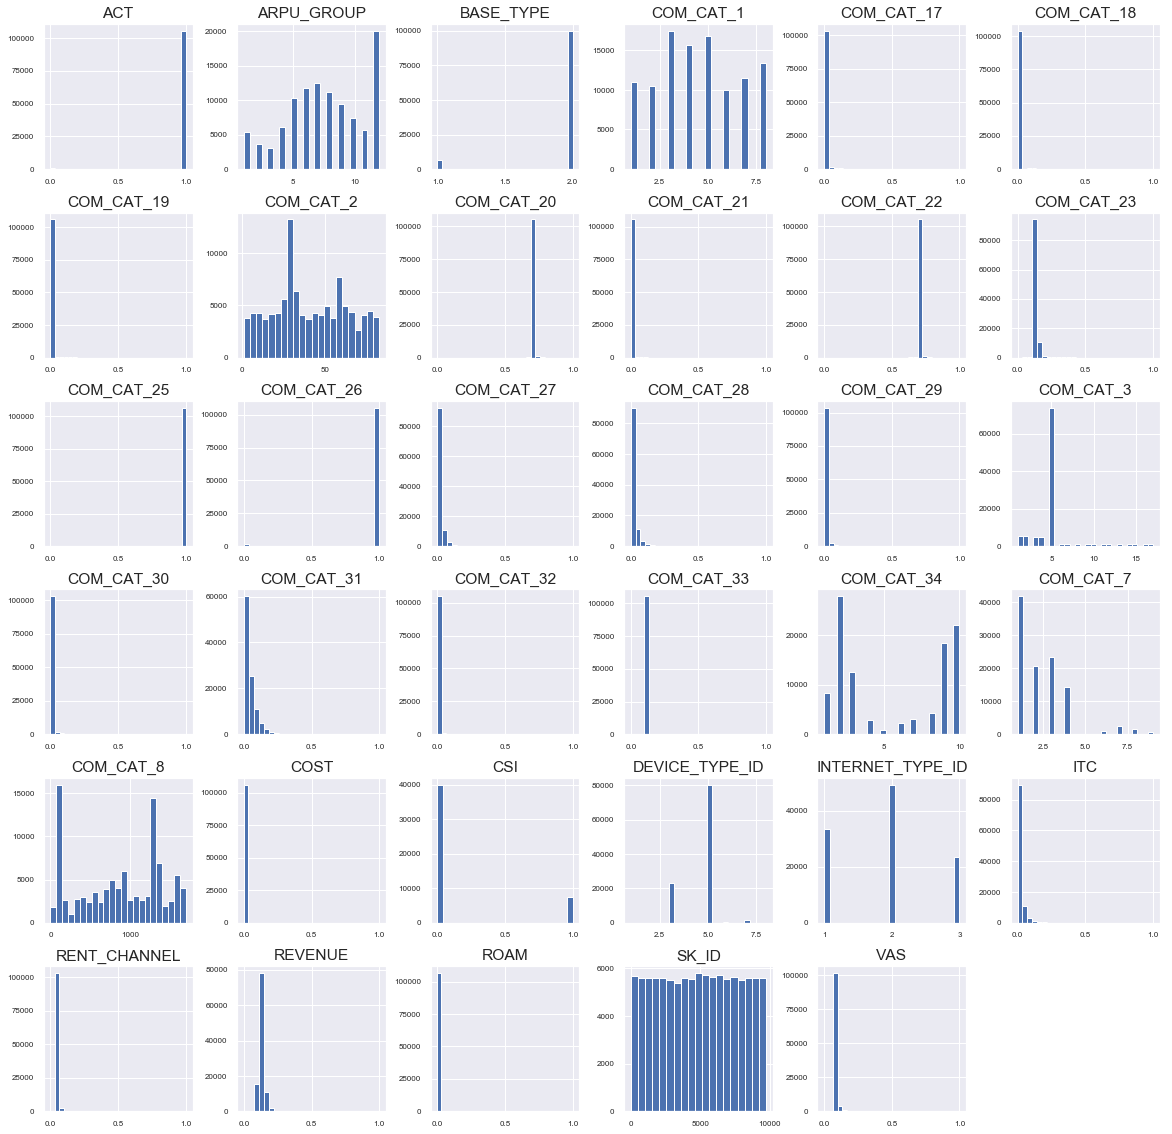

In [30]:
df[df_num_features].hist(figsize=(20, 20), bins='doane', xlabelsize=8, ylabelsize=8);

Countplots

In [31]:
for i, col in enumerate(df[df_num_features].columns.drop([target,'SK_ID'])):
    print(df[col].value_counts(normalize = True))

3    0.163976
5    0.158524
4    0.147650
8    0.126137
7    0.108327
1    0.103835
2    0.098064
6    0.093487
Name: COM_CAT_1, dtype: float64
30    0.103835
60    0.036513
32    0.027209
25    0.019737
43    0.018853
63    0.016795
77    0.014596
54    0.014549
28    0.014154
66    0.014135
40    0.014107
52    0.013976
15    0.013759
57    0.013647
68    0.013430
3     0.013299
65    0.012932
53    0.012679
24    0.012669
34    0.012641
4     0.011701
82    0.011476
59    0.011429
33    0.010883
20    0.010855
55    0.010855
58    0.010846
44    0.010836
14    0.010799
62    0.010658
        ...   
7     0.009868
18    0.009859
10    0.009840
23    0.009774
19    0.009709
78    0.009680
35    0.009521
11    0.009511
50    0.009483
2     0.009445
47    0.009398
5     0.009398
17    0.009342
31    0.009305
46    0.009267
22    0.009239
74    0.009192
49    0.009192
37    0.009098
64    0.009088
36    0.008957
76    0.008769
79    0.008562
73    0.007838
29    0.006184
81    0.004126
7

Name: COM_CAT_26, dtype: float64
0.000000    0.065291
0.000003    0.000996
0.000006    0.000630
0.000043    0.000620
0.000071    0.000536
0.000139    0.000508
0.000060    0.000508
0.000037    0.000508
0.000100    0.000498
0.000122    0.000489
0.000134    0.000489
0.000034    0.000489
0.000046    0.000489
0.000119    0.000470
0.000131    0.000461
0.000159    0.000461
0.000102    0.000451
0.000051    0.000451
0.000057    0.000442
0.000156    0.000442
0.000063    0.000432
0.000097    0.000432
0.000068    0.000423
0.000171    0.000414
0.000048    0.000414
0.000105    0.000414
0.000125    0.000404
0.000174    0.000404
0.000031    0.000404
0.000114    0.000404
              ...   
0.025595    0.000009
0.010345    0.000009
0.106026    0.000009
0.018490    0.000009
0.008925    0.000009
0.022526    0.000009
0.034515    0.000009
0.022766    0.000009
0.028488    0.000009
0.035182    0.000009
0.053640    0.000009
0.079495    0.000009
0.019644    0.000009
0.038050    0.000009
0.024864    0.000009
0

CHECK OUTLIERS FIRST!

Корреляции.

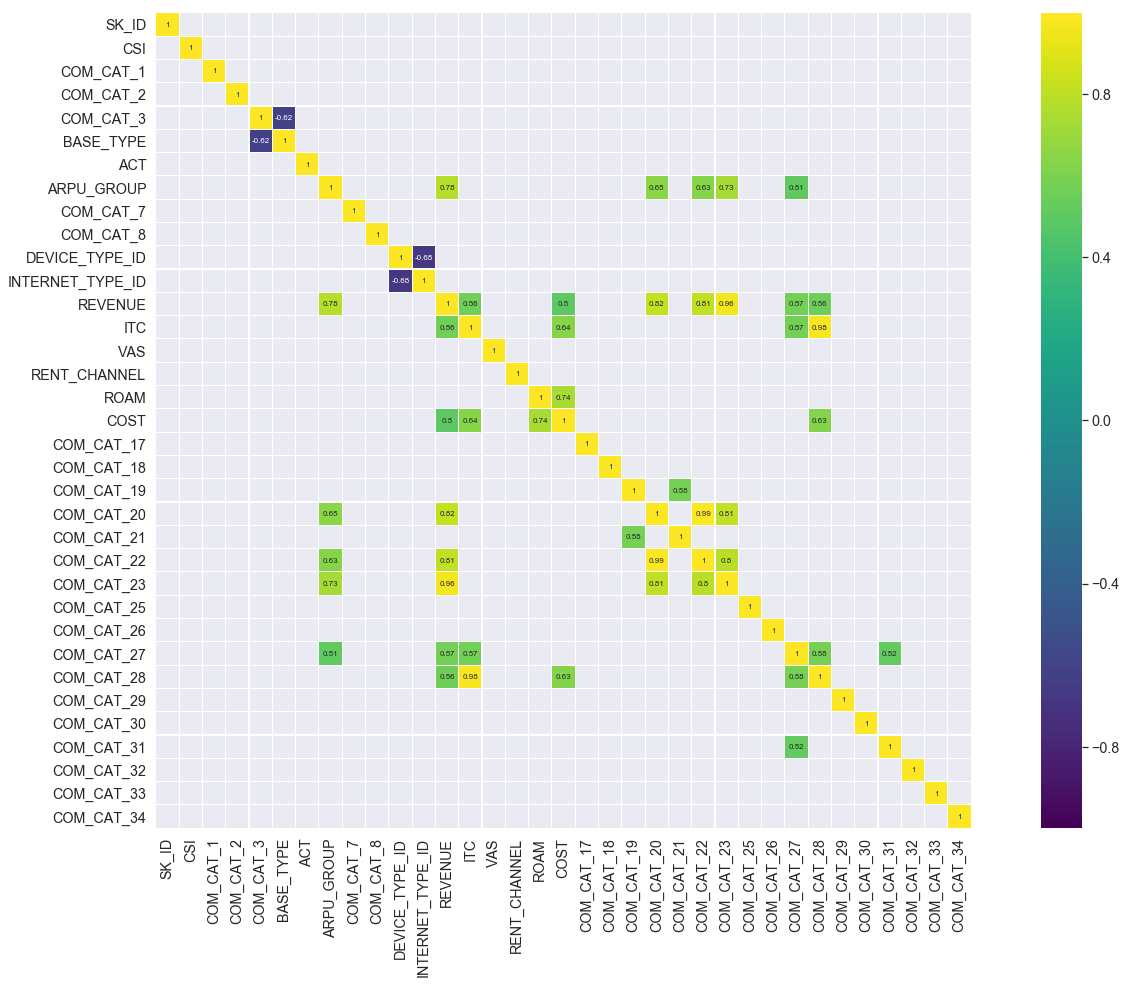

In [32]:
df_feature_corr = df.corr(method = 'pearson')

plt.figure(figsize=(25, 15))
sns.heatmap(df_feature_corr[abs(df_feature_corr) > 0.5], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

Выводы из корреляций:
1. Com_cat_3 и Base type коррелированы отрицательно.
2. ARPU Group сильнее всего связан с Revenue и Com Cat 23. ARPU = Total Revenue / # of Users.
3. Device type id and internet type id коррелированы отрицательно.
4. Revenue связан с ARPU Group и Com Cat 20, Com Cat 22 и Com Cat 23.
5. ITC с Com Cat 28.
6. ROAM с COST.
7. COST c Com Cat 28.
8. Com cat 20 c Com Cat 22 и Com Cat 23.

Обратить внимание на VAS - Value Added Services услуги, приносящие дополнительный доход.


Из анализа количества переменных в классах можно выделить:

Name: COM_CAT_25, dtype: int64

    1    47404
    0        7

Name: COM_CAT_26, dtype: int64

    1    46862
    0      549
    
    
Относительно 
- base type
- act
- com cat 17 and 18 19 - обратить внимание
- COM_CAT_20
- COM_CAT_25
- COM_CAT_26
- COM_CAT_29

In [33]:
df[df.COM_CAT_25 == 0]

,SK_ID,CSI,CONTACT_DATE,SNAP_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_25,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
9253,905,0.0,02.05,2002-01-05,4,59,1,2,1,1.0,3,1675.0,5.0,2.0,0.108027,0.000000,0.084167,0.054967,0.0,0.004206,0.000000,0.000000,0.026212,0.698438,0.019298,0.698438,0.109409,0,1,0.000247,0.000000,0.000000,0.000000,0.001175,0.027579,0.103896,10.0
9457,923,0.0,26.05,2002-01-05,4,70,5,2,1,1.0,1,1327.0,5.0,2.0,0.108111,0.000000,0.084167,0.054965,0.0,0.004206,0.000000,0.000000,0.026212,0.698467,0.019298,0.698467,0.109409,0,1,0.000614,0.000000,0.000000,0.000000,0.005066,0.027579,0.103896,10.0
17274,1694,1.0,14.05,2002-01-05,7,26,12,1,1,7.0,2,1062.0,5.0,2.0,0.121367,0.026369,0.084167,0.055048,0.0,0.006898,0.021531,0.000000,0.026212,0.701057,0.020778,0.700274,0.121836,0,1,0.004394,0.026369,0.000071,0.000004,0.016221,0.027605,0.110157,9.0
17644,1729,0.0,01.05,2002-01-05,1,30,4,2,1,4.0,1,126.0,5.0,2.0,0.111819,0.035635,0.084167,0.055410,0.0,0.007870,0.000000,0.000000,0.026212,0.696938,0.019298,0.696938,0.109409,0,1,0.016563,0.035635,0.000272,0.002276,0.047276,0.027882,0.106706,9.0
18225,1785,1.0,07.05,2002-01-05,4,36,5,2,1,1.0,7,82.0,5.0,1.0,0.107971,0.000000,0.084167,0.054968,0.0,0.004207,0.000000,0.000000,0.026212,0.698418,0.019298,0.698418,0.109409,0,1,0.000000,0.000000,0.000000,0.000000,0.005527,0.027579,0.103896,10.0
18342,1796,0.0,06.05,2002-01-05,5,60,5,2,1,8.0,3,1249.0,3.0,3.0,0.125226,0.010987,0.086559,0.056261,0.0,0.005584,0.000000,0.000000,0.026212,0.703435,0.019298,0.703435,0.122149,0,1,0.013793,0.010987,0.000036,0.013846,0.015245,0.027579,0.103896,2.0
45837,4550,0.0,25.05,2002-01-05,1,30,10,1,1,1.0,3,1627.0,5.0,2.0,0.107971,0.000000,0.084167,0.054965,0.0,0.004206,0.075694,0.000000,0.026212,0.698418,0.024502,0.695664,0.109409,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.027579,0.103896,NaN
7542,7071,NaN,07.04,2002-01-04,1,30,2,2,1,4.0,2,NaN,5.0,1.0,0.110355,0.001375,0.084167,0.055050,0.0,0.004353,0.000000,0.000000,0.026212,0.699145,0.019298,0.699145,0.109461,0,1,0.010230,0.001375,0.000406,0.000000,0.007771,0.027579,0.103896,2.0
12110,8644,NaN,25.04,2002-01-04,1,30,2,2,1,6.0,2,590.0,5.0,2.0,0.118663,0.017824,0.084167,0.055253,0.0,0.006044,0.000000,0.000000,0.026212,0.700765,0.019298,0.700765,0.115518,0,1,0.019653,0.017824,0.000994,0.000000,0.042777,0.027579,0.103896,7.0
17673,6666,NaN,13.04,2002-01-04,1,30,3,2,1,3.0,1,144.0,5.0,2.0,0.109421,0.000000,0.084167,0.054983,0.0,0.004208,0.000000,0.000000,0.026212,0.698928,0.019298,0.698928,0.109409,0,1,0.006360,0.000000,0.000000,0.000000,0.005149,0.027579,0.103896,10.0


In [34]:
df.drop('COM_CAT_25',axis = 1, inplace = True)

In [35]:
#df_union[df_union.COM_CAT_26 == 0]

Что характерно, для всех значений COM_CAT_26=0 COM_CAT_34 в основном отсутсвует.

#### Target analysis.

In [36]:
df.CSI.value_counts()

0.0    39982
1.0     7429
Name: CSI, dtype: int64

Посмотрим на вид целевой переменной в зависимости от других признаков.

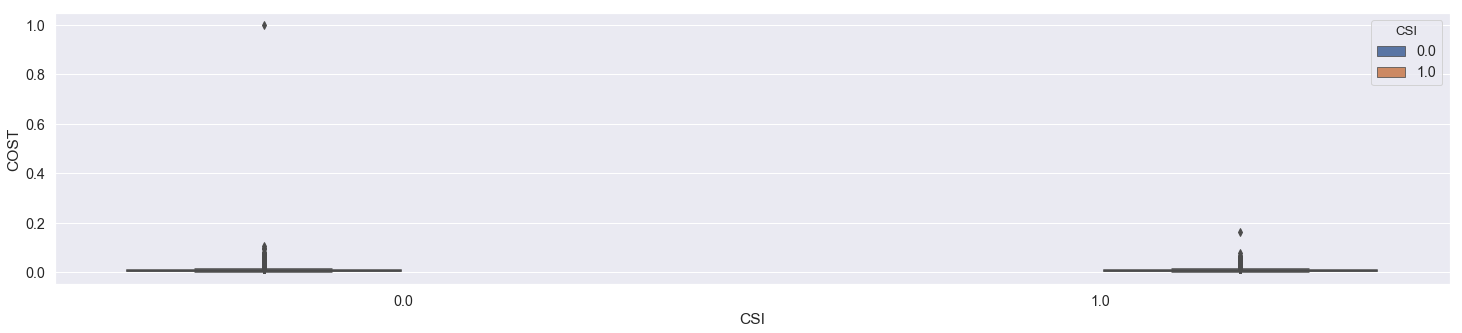

In [37]:
plt.figure(figsize=(25, 5))
sns.boxplot(x=df[target],y=df.COST, hue='CSI', data=df)
plt.show()

In [38]:
df[df.COST == 1]#скорее всего выброс

,SK_ID,CSI,CONTACT_DATE,SNAP_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
13735,1344,0.0,29.05,2001-01-08,1,30,3,2,1,12.0,1,126.0,5.0,2.0,0.314323,0.002431,0.084167,0.063686,1.0,1.0,0.0,0.0,0.026212,0.0,0.019298,0.0,0.315647,1,0.002878,0.002431,0.003612,0.045526,0.005358,0.058584,0.103896,2.0


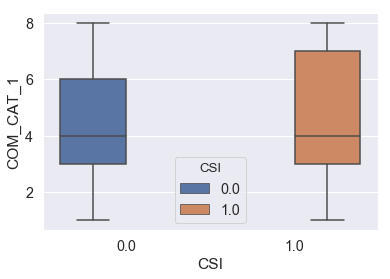

In [39]:
sns.boxplot(x=df[target],y=df.COM_CAT_1, hue='CSI', data=df)
#sns.catplot(x="day", y="total_bill", hue="smoker", kind="box", data=tips);

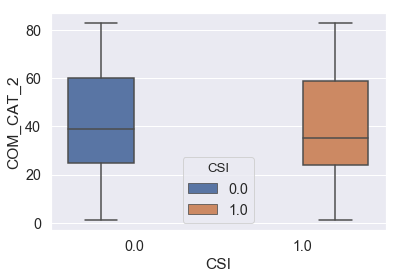

In [40]:
sns.boxplot(x=df[target],y=df.COM_CAT_2, hue='CSI', data=df)

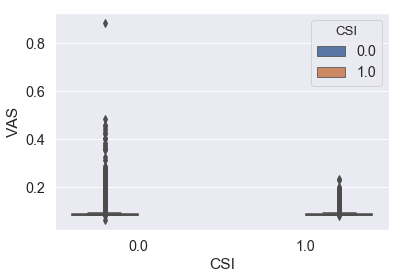

In [41]:
sns.boxplot(x=df[target],y=df.VAS, hue='CSI', data=df)
# check outlier

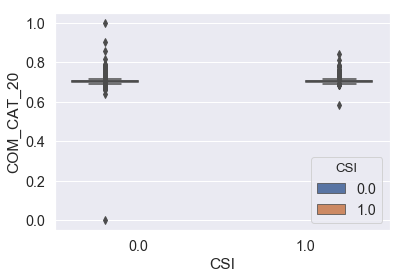

In [42]:
sns.boxplot(x=df[target],y=df.COM_CAT_20, hue='CSI', data=df) #check more 

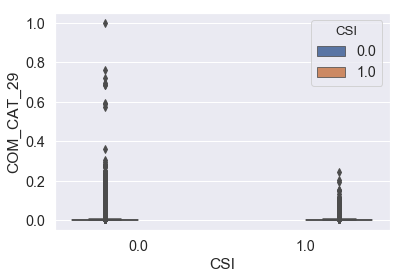

In [43]:
sns.boxplot(x=df[target],y=df.COM_CAT_29, hue='CSI', data=df) #check more 

In [44]:
df[df.COM_CAT_29 == 1]

,SK_ID,CSI,CONTACT_DATE,SNAP_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
37081,3693,0.0,22.05,2002-01-01,5,83,4,2,1,10.0,1,1520.0,5.0,2.0,0.133257,0.001914,0.085238,0.141942,0.0,0.011334,0.0,0.0,0.026212,0.701814,0.019298,0.701814,0.133496,1,0.004466,0.00183,1.0,0.0,0.010005,0.027579,0.103896,2.0


Проведем аггрегацию различных фич по SK_ID.

In [45]:
df.describe()

,SK_ID,CSI,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
count,106400.000000,47411.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106358.000000,106400.000000,101541.000000,106098.000000,106098.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,106400.000000,102936.000000
mean,4876.034201,0.156694,4.503421,41.075367,5.271100,1.939070,0.990705,7.580370,2.400451,870.832580,4.610162,1.908113,0.128907,0.018490,0.087468,0.057185,0.000050,0.006531,0.003301,0.003521,0.026593,0.704000,0.019748,0.703853,0.126349,0.988769,0.016675,0.017986,0.004444,0.004695,0.045831,0.028238,0.104961,5.582323
std,2812.580460,0.363515,2.182422,22.237932,2.783232,0.239204,0.095962,3.231712,1.625670,515.018465,0.898524,0.726753,0.020725,0.031818,0.012046,0.012992,0.003958,0.005383,0.020150,0.026469,0.010831,0.006346,0.004545,0.006369,0.018020,0.105381,0.024760,0.030927,0.015495,0.021385,0.051868,0.009022,0.009838,3.557936
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2436.000000,0.000000,3.000000,25.000000,5.000000,2.000000,1.000000,5.000000,1.000000,391.000000,5.000000,1.000000,0.115454,0.001027,0.084167,0.054996,0.000000,0.004429,0.000000,0.000000,0.026212,0.700358,0.019298,0.700214,0.115037,1.000000,0.002037,0.000960,0.000000,0.000000,0.010774,0.027579,0.103896,2.000000
50%,4889.000000,0.000000,4.000000,38.000000,5.000000,2.000000,1.000000,8.000000,2.000000,926.000000,5.000000,2.000000,0.124508,0.006953,0.084212,0.055156,0.000000,0.005209,0.000000,0.000000,0.026212,0.702849,0.019298,0.702705,0.122497,1.000000,0.008221,0.006679,0.000070,0.000000,0.030382,0.027579,0.103896,4.000000
75%,7310.000000,0.000000,6.000000,60.000000,5.000000,2.000000,1.000000,10.000000,3.000000,1318.000000,5.000000,2.000000,0.136094,0.022675,0.086573,0.056061,0.000000,0.007087,0.000000,0.000000,0.026212,0.705948,0.019298,0.705816,0.131878,1.000000,0.021532,0.022035,0.002882,0.000190,0.062889,0.027579,0.103896,9.000000
max,9748.000000,1.000000,8.000000,83.000000,17.000000,2.000000,1.000000,12.000000,9.000000,1702.000000,8.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000


In [46]:
df_aggregate_test = df[(df.SK_ID == 2) | (df.SK_ID == 3339)]

In [47]:
# check what if in some variables customer can have more than value of characteristics
# check for ARPU_GROUP
df.COM_CAT_26.value_counts()

1    105205
0      1195
Name: COM_CAT_26, dtype: int64

In [48]:
df_aggregate_test

,SK_ID,CSI,CONTACT_DATE,SNAP_DATE,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
0,2,0.0,04.05,2002-01-03,7,77,10,1,1,10.0,2,1318.0,5.0,2.0,0.133708,0.007335,0.084167,0.055325,0.0,0.004982,0.0,0.0,0.026212,0.706893,0.019298,0.706893,0.133897,1,0.002070,0.007335,0.000050,0.002785,0.029765,0.027579,0.103896,NaN
1,2,0.0,04.05,2002-01-02,7,77,9,1,1,10.0,2,1318.0,5.0,2.0,0.134224,0.001590,0.084167,0.055312,0.0,0.004396,0.0,0.0,0.026212,0.707528,0.019298,0.707528,0.134836,1,0.003913,0.001590,0.000018,0.001954,0.054871,0.027579,0.103896,NaN
2,2,0.0,04.05,2002-01-05,7,77,12,1,1,9.0,2,1318.0,5.0,2.0,0.128917,0.008331,0.084167,0.055257,0.0,0.005078,0.0,0.0,0.026212,0.705129,0.019298,0.705129,0.129093,1,0.001801,0.008317,0.000081,0.002441,0.018126,0.027579,0.103896,9.0
3,2,0.0,04.05,2002-01-01,7,77,17,1,1,6.0,2,1318.0,5.0,2.0,0.117077,0.002301,0.084167,0.055353,0.0,0.004471,0.0,0.0,0.087185,0.701424,0.086379,0.697846,0.118129,0,0.001798,0.002048,0.000033,0.002331,0.022108,0.027579,0.103896,NaN
4,2,0.0,04.05,2002-01-04,7,77,11,1,1,8.0,2,1318.0,5.0,2.0,0.126715,0.002080,0.084167,0.055187,0.0,0.004436,0.0,0.0,0.026212,0.704850,0.019298,0.704850,0.126587,1,0.006520,0.001408,0.000010,0.001709,0.022772,0.027579,0.103896,9.0
33577,3339,1.0,13.05,2001-01-08,4,80,5,2,1,12.0,1,1489.0,5.0,2.0,0.153024,0.081527,0.104168,0.058596,0.0,0.014106,0.0,0.0,0.026212,0.706638,0.019298,0.706638,0.147071,1,0.031696,0.076724,0.040279,0.013300,0.083382,0.027579,0.103896,2.0
33578,3339,1.0,13.05,2002-01-01,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.150506,0.048746,0.090899,0.056983,0.0,0.009771,0.0,0.0,0.026212,0.709107,0.019298,0.709107,0.139332,1,0.055658,0.048290,0.026180,0.014695,0.073732,0.027579,0.103896,2.0
33579,3339,1.0,13.05,2001-01-06,4,80,5,2,1,12.0,1,1489.0,5.0,2.0,0.143226,0.022492,0.084648,0.056036,0.0,0.006612,0.0,0.0,0.026212,0.708986,0.019298,0.708986,0.138648,1,0.026727,0.022298,0.011269,0.000004,0.163625,0.027579,0.103896,2.0
33580,3339,1.0,13.05,2001-01-12,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.152471,0.087388,0.088690,0.058714,0.0,0.013697,0.0,0.0,0.026212,0.706760,0.019298,0.706760,0.136914,1,0.073945,0.086367,0.032632,0.017697,0.107121,0.027579,0.103896,2.0
33581,3339,1.0,13.05,2001-01-10,4,80,5,2,1,12.0,1,1627.0,5.0,2.0,0.142156,0.033726,0.089917,0.059585,0.0,0.008382,0.0,0.0,0.026212,0.707238,0.019298,0.707238,0.135508,1,0.035139,0.033726,0.030531,0.053506,0.114678,0.027579,0.103896,2.0


SyntaxError: Missing parentheses in call to 'print'. Did you mean print(test)? (<ipython-input-49-f95b3ffdade0>, line 1)

In [54]:
df_agg = df.groupby('SK_ID',sort=False).agg({
    'CSI' : ['mean'],
    'COM_CAT_1': ['mean'],
    'COM_CAT_2': 'mean', 
    'COM_CAT_3' :'mean',
    'BASE_TYPE' : 'first',
    'ACT' : 'median',
    'ARPU_GROUP' : 'mean',
    'COM_CAT_7': 'first',
    'COM_CAT_8' : 'mean',
    'DEVICE_TYPE_ID' : 'first',
    'INTERNET_TYPE_ID' : 'first', 
    'REVENUE' : 'mean',
    'ITC' : 'mean',
    'VAS' : 'mean',
    'RENT_CHANNEL' : 'mean',
    'ROAM' : 'mean',
    'COST' : 'mean',
    'COM_CAT_17' : 'mean',
    'COM_CAT_18' : 'mean',
    'COM_CAT_19' : 'mean',
    'COM_CAT_20' : 'mean',
    'COM_CAT_21' : 'mean',
    'COM_CAT_22' : 'mean',
    'COM_CAT_23' : 'mean',
    'COM_CAT_26' : 'mean',
    'COM_CAT_27' : 'mean',
    'COM_CAT_28' : 'mean',
    'COM_CAT_29' : 'mean',
    'COM_CAT_30' : 'mean',
    'COM_CAT_31' : 'mean',
    'COM_CAT_32' : 'mean',
    'COM_CAT_33' : 'mean',
    'COM_CAT_34' : 'mean'
})



In [55]:
df_agg

,CSI,COM_CAT_1,COM_CAT_2,COM_CAT_3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT_7,COM_CAT_8,DEVICE_TYPE_ID,INTERNET_TYPE_ID,REVENUE,ITC,VAS,RENT_CHANNEL,ROAM,COST,COM_CAT_17,COM_CAT_18,COM_CAT_19,COM_CAT_20,COM_CAT_21,COM_CAT_22,COM_CAT_23,COM_CAT_26,COM_CAT_27,COM_CAT_28,COM_CAT_29,COM_CAT_30,COM_CAT_31,COM_CAT_32,COM_CAT_33,COM_CAT_34
,mean,mean,mean,mean,first,median,mean,first,mean,first,first,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
SK_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,7,77.0,11.800000,1,1.0,8.600000,2,1318.000000,5.0,2.0,0.128128,0.004327,0.084167,0.055287,0.000000,0.004673,0.000000,0.000000,0.038407,0.705165,0.032714,0.704449,0.128508,0.800000,0.003220,0.004140,3.840000e-05,2.244000e-03,0.029528,0.027579,0.103896,9.000000
3,0.0,4,51.0,13.000000,1,1.0,8.222222,2,751.444444,5.0,2.0,0.133601,0.015793,0.106932,0.055055,0.000000,0.007315,0.068165,0.000000,0.026212,0.705048,0.023984,0.702567,0.132894,0.888889,0.008828,0.015793,9.724444e-04,6.966667e-05,0.011613,0.027579,0.103896,9.000000
4,0.0,8,12.0,3.833333,2,1.0,6.166667,3,1102.333333,3.0,3.0,0.118478,0.004834,0.085881,0.055038,0.000000,0.004817,0.000000,0.000000,0.026212,0.701650,0.019298,0.701650,0.116275,1.000000,0.014066,0.003972,0.000000e+00,0.000000e+00,0.039371,0.027579,0.103896,3.000000
5,0.0,3,79.0,2.000000,2,1.0,8.833333,1,110.000000,5.0,2.0,0.129951,0.002000,0.085055,0.063784,0.000000,0.005164,0.000000,0.000000,0.026212,0.705427,0.019298,0.705427,0.130530,1.000000,0.003737,0.002000,7.133242e-02,1.832750e-03,0.051395,0.027579,0.103896,2.000000
6,1.0,5,48.0,5.000000,2,1.0,2.166667,4,937.000000,3.0,3.0,0.108780,0.000103,0.084285,0.054984,0.000000,0.004226,0.000000,0.000000,0.026212,0.698688,0.019298,0.698688,0.109785,1.000000,0.001804,0.000103,0.000000e+00,0.000000e+00,0.012235,0.027579,0.103900,3.000000
7,0.0,7,73.0,3.333333,2,1.0,10.000000,2,1299.666667,5.0,1.0,0.134504,0.037298,0.084560,0.056232,0.000000,0.008130,0.000000,0.000000,0.026212,0.704736,0.019298,0.704736,0.128094,1.000000,0.032011,0.036967,9.840667e-03,1.591833e-03,0.047106,0.027579,0.104090,2.000000
8,1.0,5,41.0,3.333333,2,1.0,7.166667,4,1244.000000,3.0,3.0,0.122718,0.035249,0.084388,0.055009,0.000000,0.007813,0.000000,0.000000,0.026212,0.700825,0.019298,0.700825,0.122367,1.000000,0.007997,0.035177,0.000000e+00,0.000000e+00,0.023366,0.027579,0.103896,3.000000
9,0.0,5,60.0,5.000000,2,1.0,3.250000,4,1218.333333,5.0,1.0,0.110662,0.000767,0.084361,0.054973,0.000000,0.004298,0.000000,0.000000,0.026212,0.699296,0.019298,0.699296,0.111628,1.000000,0.002095,0.000767,4.166667e-07,0.000000e+00,0.003845,0.027579,0.103896,10.000000


In [ ]:
#transfrom quantiles

#### Baseline.

In [ ]:
df_num_features = df.select_dtypes([np.number]).columns

In [ ]:
df_cat_features = df.select_dtypes([np.object,'datetime']).columns

In [ ]:
df_num_features